# DSL Winter 2020 Assignment

> **TASK**: Build a robust classification model for sentiment analysis of _Tripadvisor_ reviews


## Dataset

The dataset contains italian reviews from [tripadvisor.it](http://tripadvisor.it) Italian website. It's divided into two different sets:
- _Development set_ : labeled data ( _'pos'_ and _'neg'_ labels, for positive and negative reviews respectively) on which the model can be trained.
- _Evaluation set_ : unlabeled data whose labels must be predicted and submitted to the competition link.

### Data loading
First we need to load the data. This can be easily done with `pandas` library.

In [1]:
import os
import pandas as pd
# set file directories
source_dir = 'dataset_winter_2020'
dev_file = os.path.join(source_dir, 'development.csv')
eval_file = os.path.join(source_dir, 'evaluation.csv')

# read both development and evaluation CSV file as pandas Dataframes
dev_df = pd.read_csv(dev_file, header=0)
eval_df = pd.read_csv(eval_file, header=0)

### Data exploration
Next we can take a closer look at the reviews, extracting some useful information which can help during the preprocessing and model selection phase.

In [4]:
print(f"Development dataset size: {dev_df['text'].size}")
print(f"Development dataset size: {eval_df['text'].size}")

Development dataset size: 28754
Development dataset size: 12323


/home/toyo/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


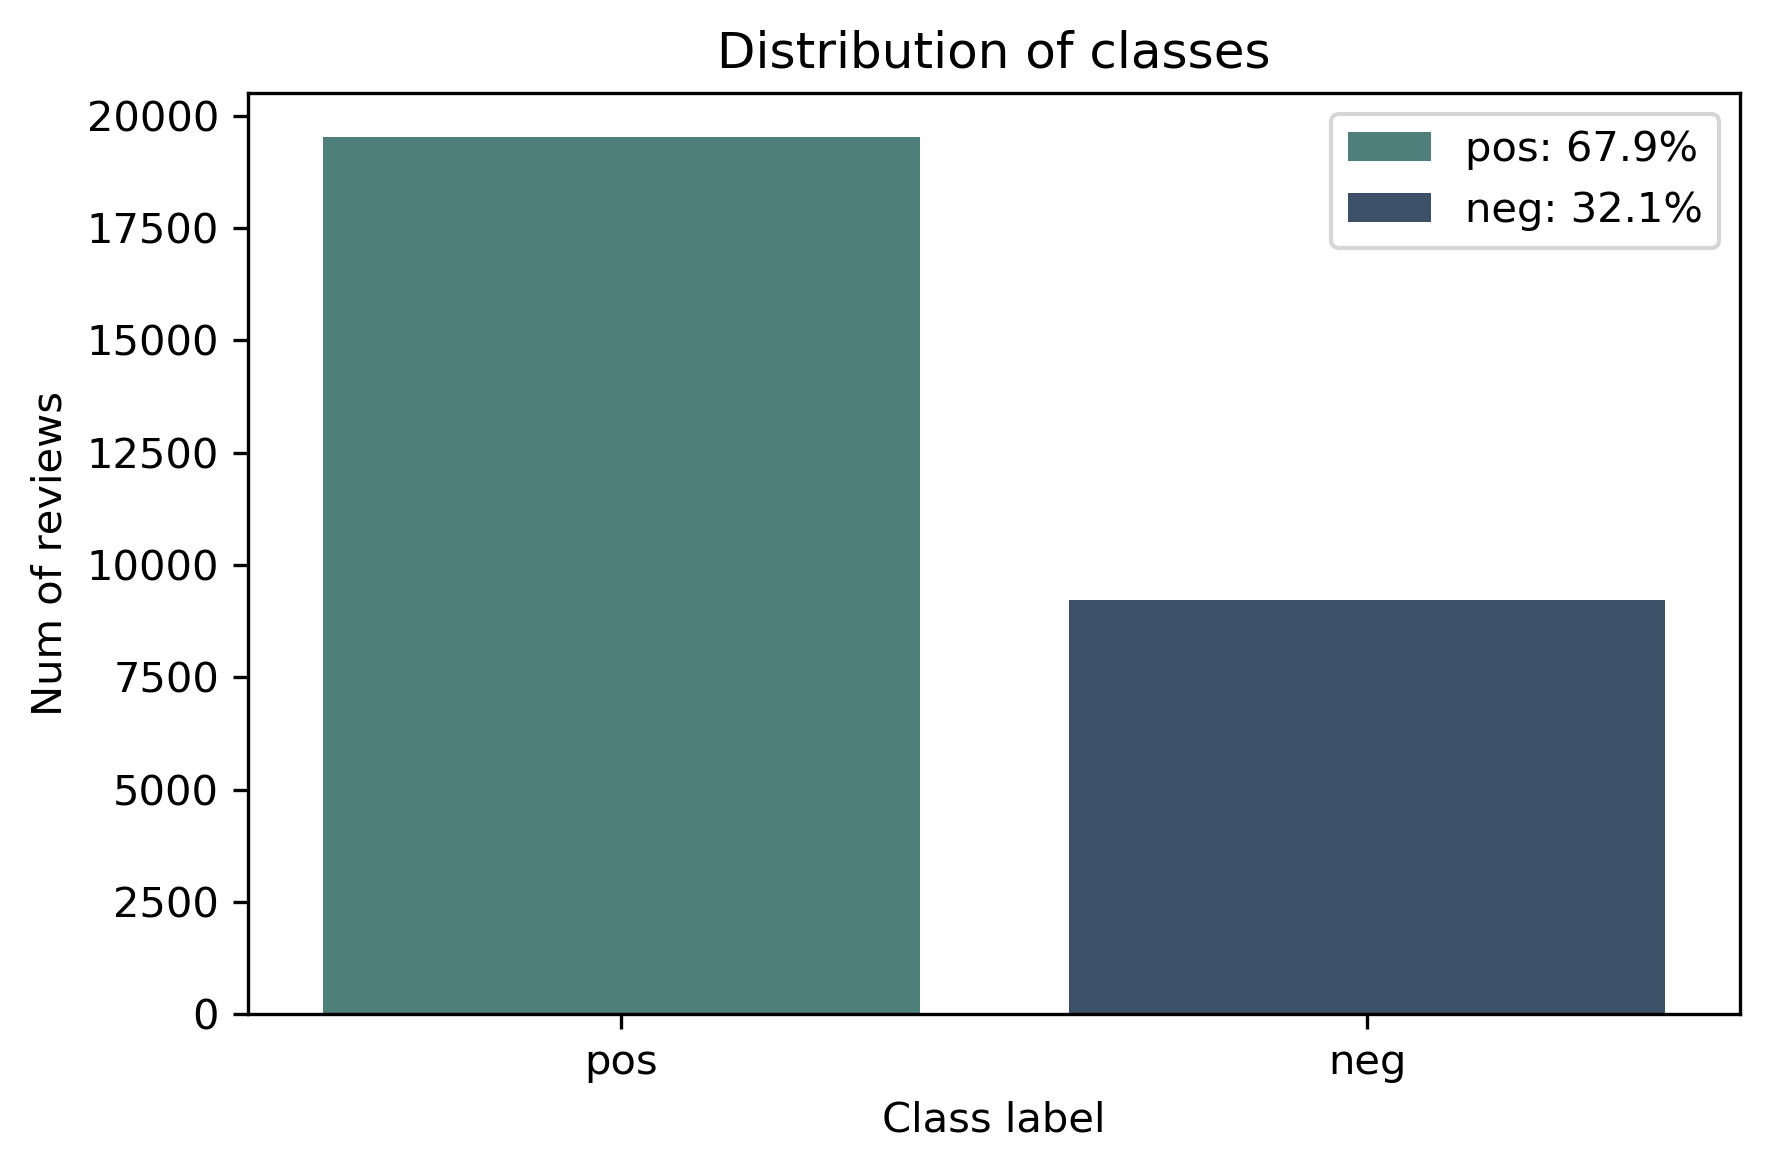

In [101]:
import seaborn as sns
import matplotlib.pyplot as plt
# compute percentages
pos_perc = 100 * dev_df[dev_df['class'] == 'pos'].size / dev_df.size
neg_perc = 100 - pos_perc

fig, ax = plt.subplots(dpi=300)
ax = sns.countplot(x='class', data=dev_df,
              palette=sns.cubehelix_palette(2, start=.4, rot=-.75, light=.45, dark=.3))
ax.set_ylabel('Num of reviews')
ax.set_xlabel('Class label')
ax.set_title('Distribution of classes')
ax.legend(handles=ax.patches, labels=(f'pos: {pos_perc:.1f}%', f'neg: {neg_perc:.1f}%'))
fig.tight_layout()
fig.show()

From the above plot we can see that the dataset is quite unbalanced towards positive reviews. Assuming that the distribution of the evaluation set is similar (_i.e._ the given dataset is a fair set of samples) we should not consider it as biased and therefore we should not re-balance the dataset during the preprocessing phase.

That being said, unbalanced data can be a problem for many machine learning algorithms (_e.g._ decision trees) but the imbalance in our case is not really significant (around 2 positive reviews for each negative one) and therefore we should not care too much about it.

Among the two classes, it would be interesting to analyze some immediate features of the text, for instance the review length.

/home/toyo/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


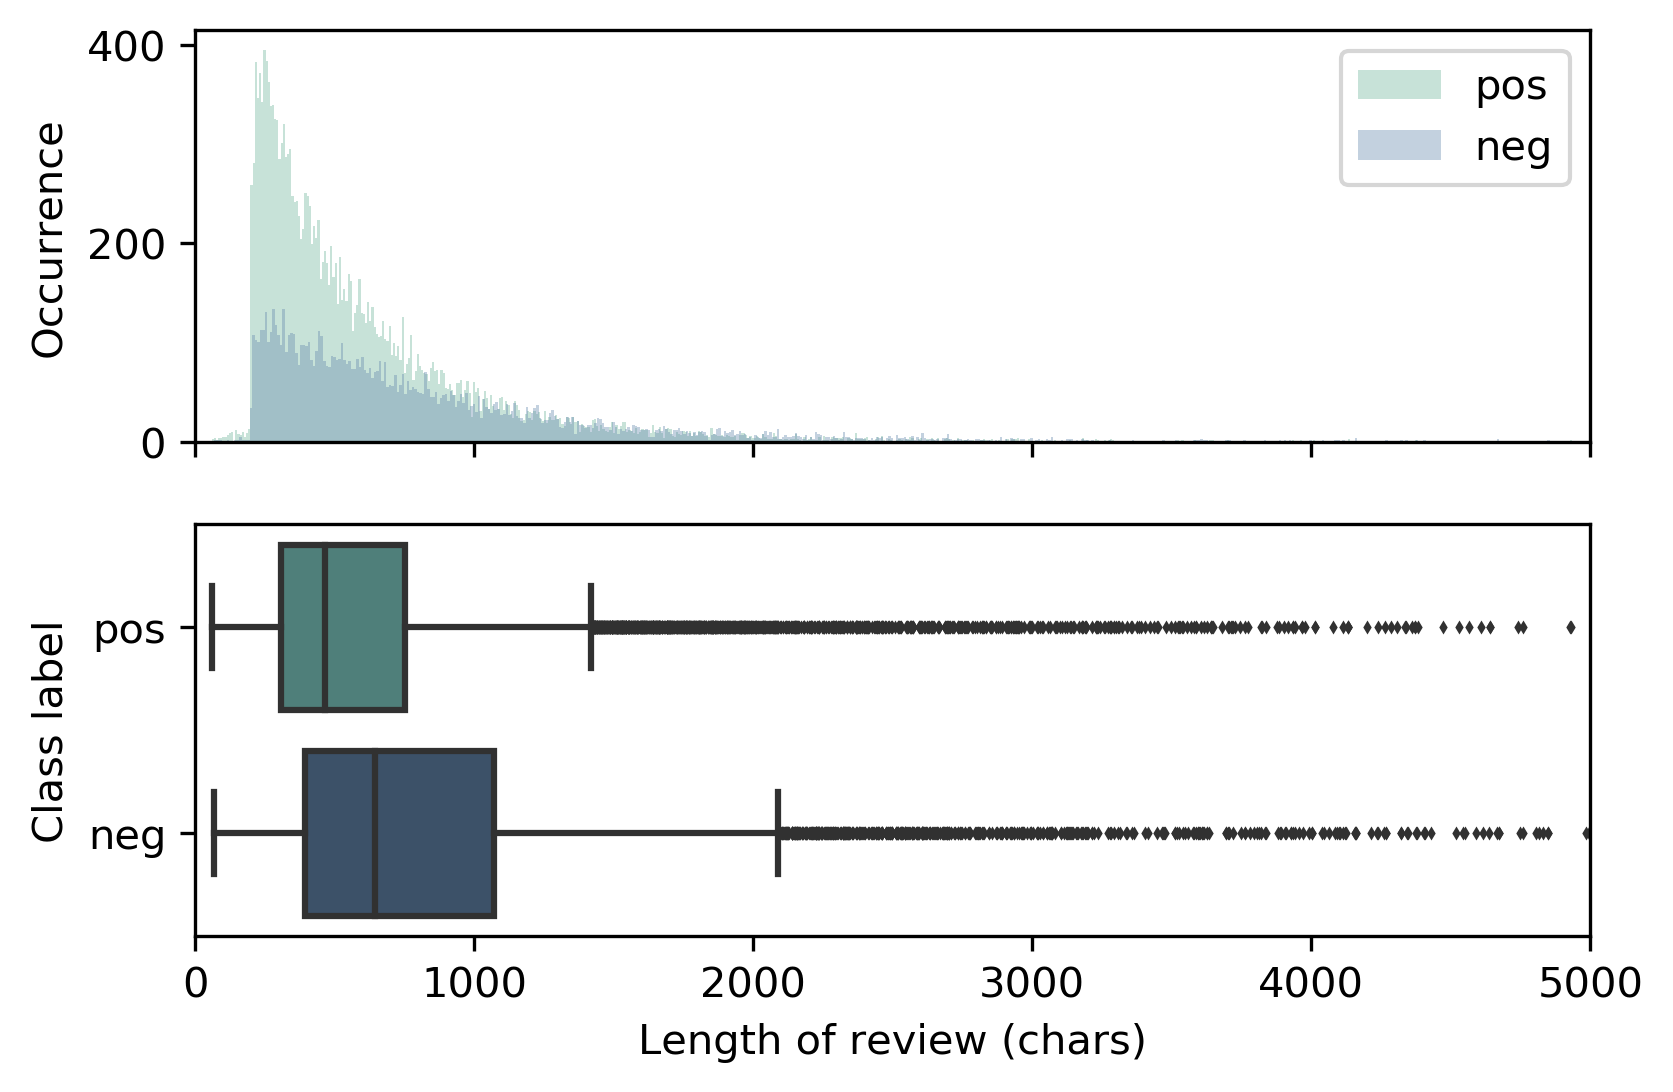

In [6]:
# compute the length of every review and store it in a new column `textlen`
dev_df['textlen'] = dev_df['text'].str.len()

# plot histogram and boxplot
fig, axs = plt.subplots(nrows=2, sharex='col', dpi=300)
sns.distplot(dev_df['textlen'][dev_df['class']=='pos'],
             bins=1000, ax=axs[0], kde=False, label='pos', color='#75b79e')
sns.distplot(dev_df['textlen'][dev_df['class']=='neg'],
             bins=1000, ax=axs[0], kde=False, label='neg', color='#6a8caf')
axs[0].legend()
axs[0].set_ylabel('Occurrence')

axs[1] = sns.boxplot(y='class', x='textlen', data=dev_df, fliersize=1,
                 palette=sns.cubehelix_palette(2, start=.4, rot=-.75, light=.45, dark=.3))
axs[1].set_ylabel('Class label')

for ax in axs:
    ax.set_xlabel('Length of review (chars)')
    # cut out part of the outliers for better visualization
    ax.set_xlim(0,5000)
    ax.label_outer()
    
fig.show()

As we can see from the visuals, text length is more or less equally distributed among the two review classes. This means that we can not exploit this text feature to better characterize the two classes. The task is therefore accomplished mainly by a proper natural language processing (NLP) step.

## Pre-processing

### Text cleaning
The first pre-processing step that must be done is _text cleaning,_ _i.e._ selecting the most relevant words (or more in general _tokens_ ) to feed the machine learning algorithm with.
The main issue raised by this step is the language of the text in the dataset: the Italian language is naturally not studied as deeply as the English one in text analysis literature. Many state-of-the-art text analysis methods are available for english text feature extraction, unfortunately this does not hold also for Italian.

Many ways to extract relevant tokens have been tested, below it is presented the most successful one.

Text has been tokenized and POS-tagged with the tool [TreeTagger](https://www.cis.uni-muenchen.de/~schmid/tools/TreeTagger/) which is available in many languages.
For our purpose, it also comes handy `treetaggerwrapper` library which handles TreeTagger data in a Python environment (see [TreeTaggerWrapper](https://perso.limsi.fr/pointal/doku.php?id=dev:treetaggerwrapper) for further details).

In [8]:
import treetaggerwrapper as ttw
from pprint import pprint

tagger = ttw.TreeTagger(TAGLANG='it')
it_string = "Il mattino ha l'oro in bocca."
tags = tagger.tag_text(it_string)
pprint(ttw.make_tags(tags))

[Tag(word='Il', pos='DET:def', lemma='il'),
 Tag(word='mattino', pos='NOM', lemma='mattino'),
 Tag(word='ha', pos='VER:pres', lemma='avere'),
 Tag(word="l'", pos='DET:def', lemma='il'),
 Tag(word='oro', pos='NOM', lemma='oro'),
 Tag(word='in', pos='PRE', lemma='in'),
 Tag(word='bocca', pos='NOM', lemma='bocca'),
 Tag(word='.', pos='SENT', lemma='.')]


As shown in the code above, this tagger recognises very well part-of-speech tags, as well as the base forms of the words ( _lemmas_ ), contrarily to other Italian lemmatization tools like [Spacy's Italian model](https://spacy.io/models/it). Other approaches like stemmatization with [NLTK SnowballStemmer](https://kite.com/python/docs/nltk.SnowballStemmer) have been evaluated but did not provide better quality results for this task.

Since text data is notoriously one of the most unstructured type of data, along with the lemmatization step, also a filtering step is needed so as to clean the reviews from stopwords, punctuation and unwanted text content (like typos, symbols, urls, numbers etc.).
This step has being carried out with the creation of a small pipeline as shown below.

In [49]:
import re

class TreeTaggerTokenizer(object):
    def __init__(self):
        # instantiate the tree tagger
        self.tt_it = ttw.TreeTagger(TAGLANG='it')
        
    def __call__(self, document):
        # some regex to optimize filtering step
        re_alpha = re.compile(r"^[a-zA-Z][a-zA-Z]+$")  # match only alpha characters (with len>1)
        re_sw_tag = re.compile('^([CDFLP]|NUM|SENT).*')  # match conjunctions, articles,
                                                # foreign words, punctuation, numerals, etc.
        # match too common verbs
        re_sw = re.compile('^(essere|avere|stare|andare|fare|essere\|stare)$')
        
        tokens = ttw.make_tags(self.tt_it.tag_text(document))
        lemmas = []
        # tag[0] : original word
        # tag[1] : POS tag
        # (see https://www.cis.uni-muenchen.de/~schmid/tools/TreeTagger/data/italian-tagset.txt)
        # tag[2] : base form (lemma)
        for tag in tokens:
            if re_alpha.match(tag[0]) and \
                len(tag) > 1 and \
                not re_sw_tag.match(tag[1]) and \
                not re_sw.match(tag[2]):
                lemmas.append(tag[2])

        return lemmas

In [53]:
tt_tokenizer = TreeTaggerTokenizer()
print(it_string + ' -> ' + str(tt_tokenizer(it_string)))

Il mattino ha l'oro in bocca. -> ['mattino', 'oro', 'bocca']


### Feature extraction
Now that we have the tokens, we must process them to actually extract text features.
The most common text feature extraction approaches make use of the token counts or the TF-IDF statistics.
To better understand which one is more suitable for our purpose we have to consider the context of our dataset.
Since the reviews all belong to hotel opinions, many words such as _hotel, albergo, camera, notti, etc._ will be present with high occurrence in both review classes. The absolute count statistic will therefore assign high value to those tokens, while it is easily understood that they will not provide useful insights on the positiveness of the review.
Hence the choice of the TF-IDF statistic, which, thanks to the Inverse Document Frequency property, gives lower importance to the above mentioned words.

Lastly, we can set the TF-IDF step in order to consider not only one word but also pairs of words (bigrams). This enables the possibility of taking into account negations like _'non buono', 'non male'_ which will help in our sentiment analysis task. Of course this step increases exponentially the number of features, therefore it may be reasonable to limit the number of features to a fixed number ( _e.g._ 20k is a sufficiently large number to grasp all the useful words or pairs of words, lower order of magnitudes such as $10^2$ or $10^3$ have been found to be too restrictive).
The choice is also supported by cross validation scores obtained with both the options (single words or single words plus bigrams)

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(tokenizer=tt_tokenizer, max_features=20000,
                            ngram_range=(1,2))

X_dev_tfidf = tfidf_vect.fit_transform(dev_df['text'])

We can now analyze the outcome of the TF-IDF preprocessing step by generating two wordclouds showing the most frequent (in terms of TF-IDF frequency) words among the two review classes.

In [46]:
from wordcloud import WordCloud

# generate wordcloud of the given class from the tfidf matrix with a maximum of 100 words
def generate_wordcloud(label, X_tfidf, y_dev, tfidf_vectorizer, top_count=100):
    word_positions = {v: k for k, v in tfidf_vectorizer.vocabulary_.items()}

    tfidf = X_tfidf[y_dev == label]
    tfidf_sum = np.sum(tfidf, axis=0)
    tfidf_sum = np.asarray(tfidf_sum).reshape(-1)
    top_indices = tfidf_sum.argsort()[-top_count:]

    term_weights = {word_positions[idx]: tfidf_sum[idx] for idx in top_indices}

    wc = WordCloud(width=1200, height=800, background_color="white")
    wordcloud = wc.generate_from_frequencies(term_weights)

    fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

    ax.imshow(wordcloud, interpolation='bilinear')

    ax.axis("off")
    title = 'Positive' if label == 1 else 'Negative'
    fig.suptitle(title)
    return fig, ax

In [22]:
import numpy as np
# create a mapping between the two class labels and the binary pair {0,1}
# this will come handy also in the next steps
lab_map = {'pos': 1, 'neg': 0}
inv_lab_map = ['neg', 'pos']

# map labels of the development set
y_dev = np.array(list(map(lambda x: lab_map[x], dev_df.values[:, 1])))

/home/toyo/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


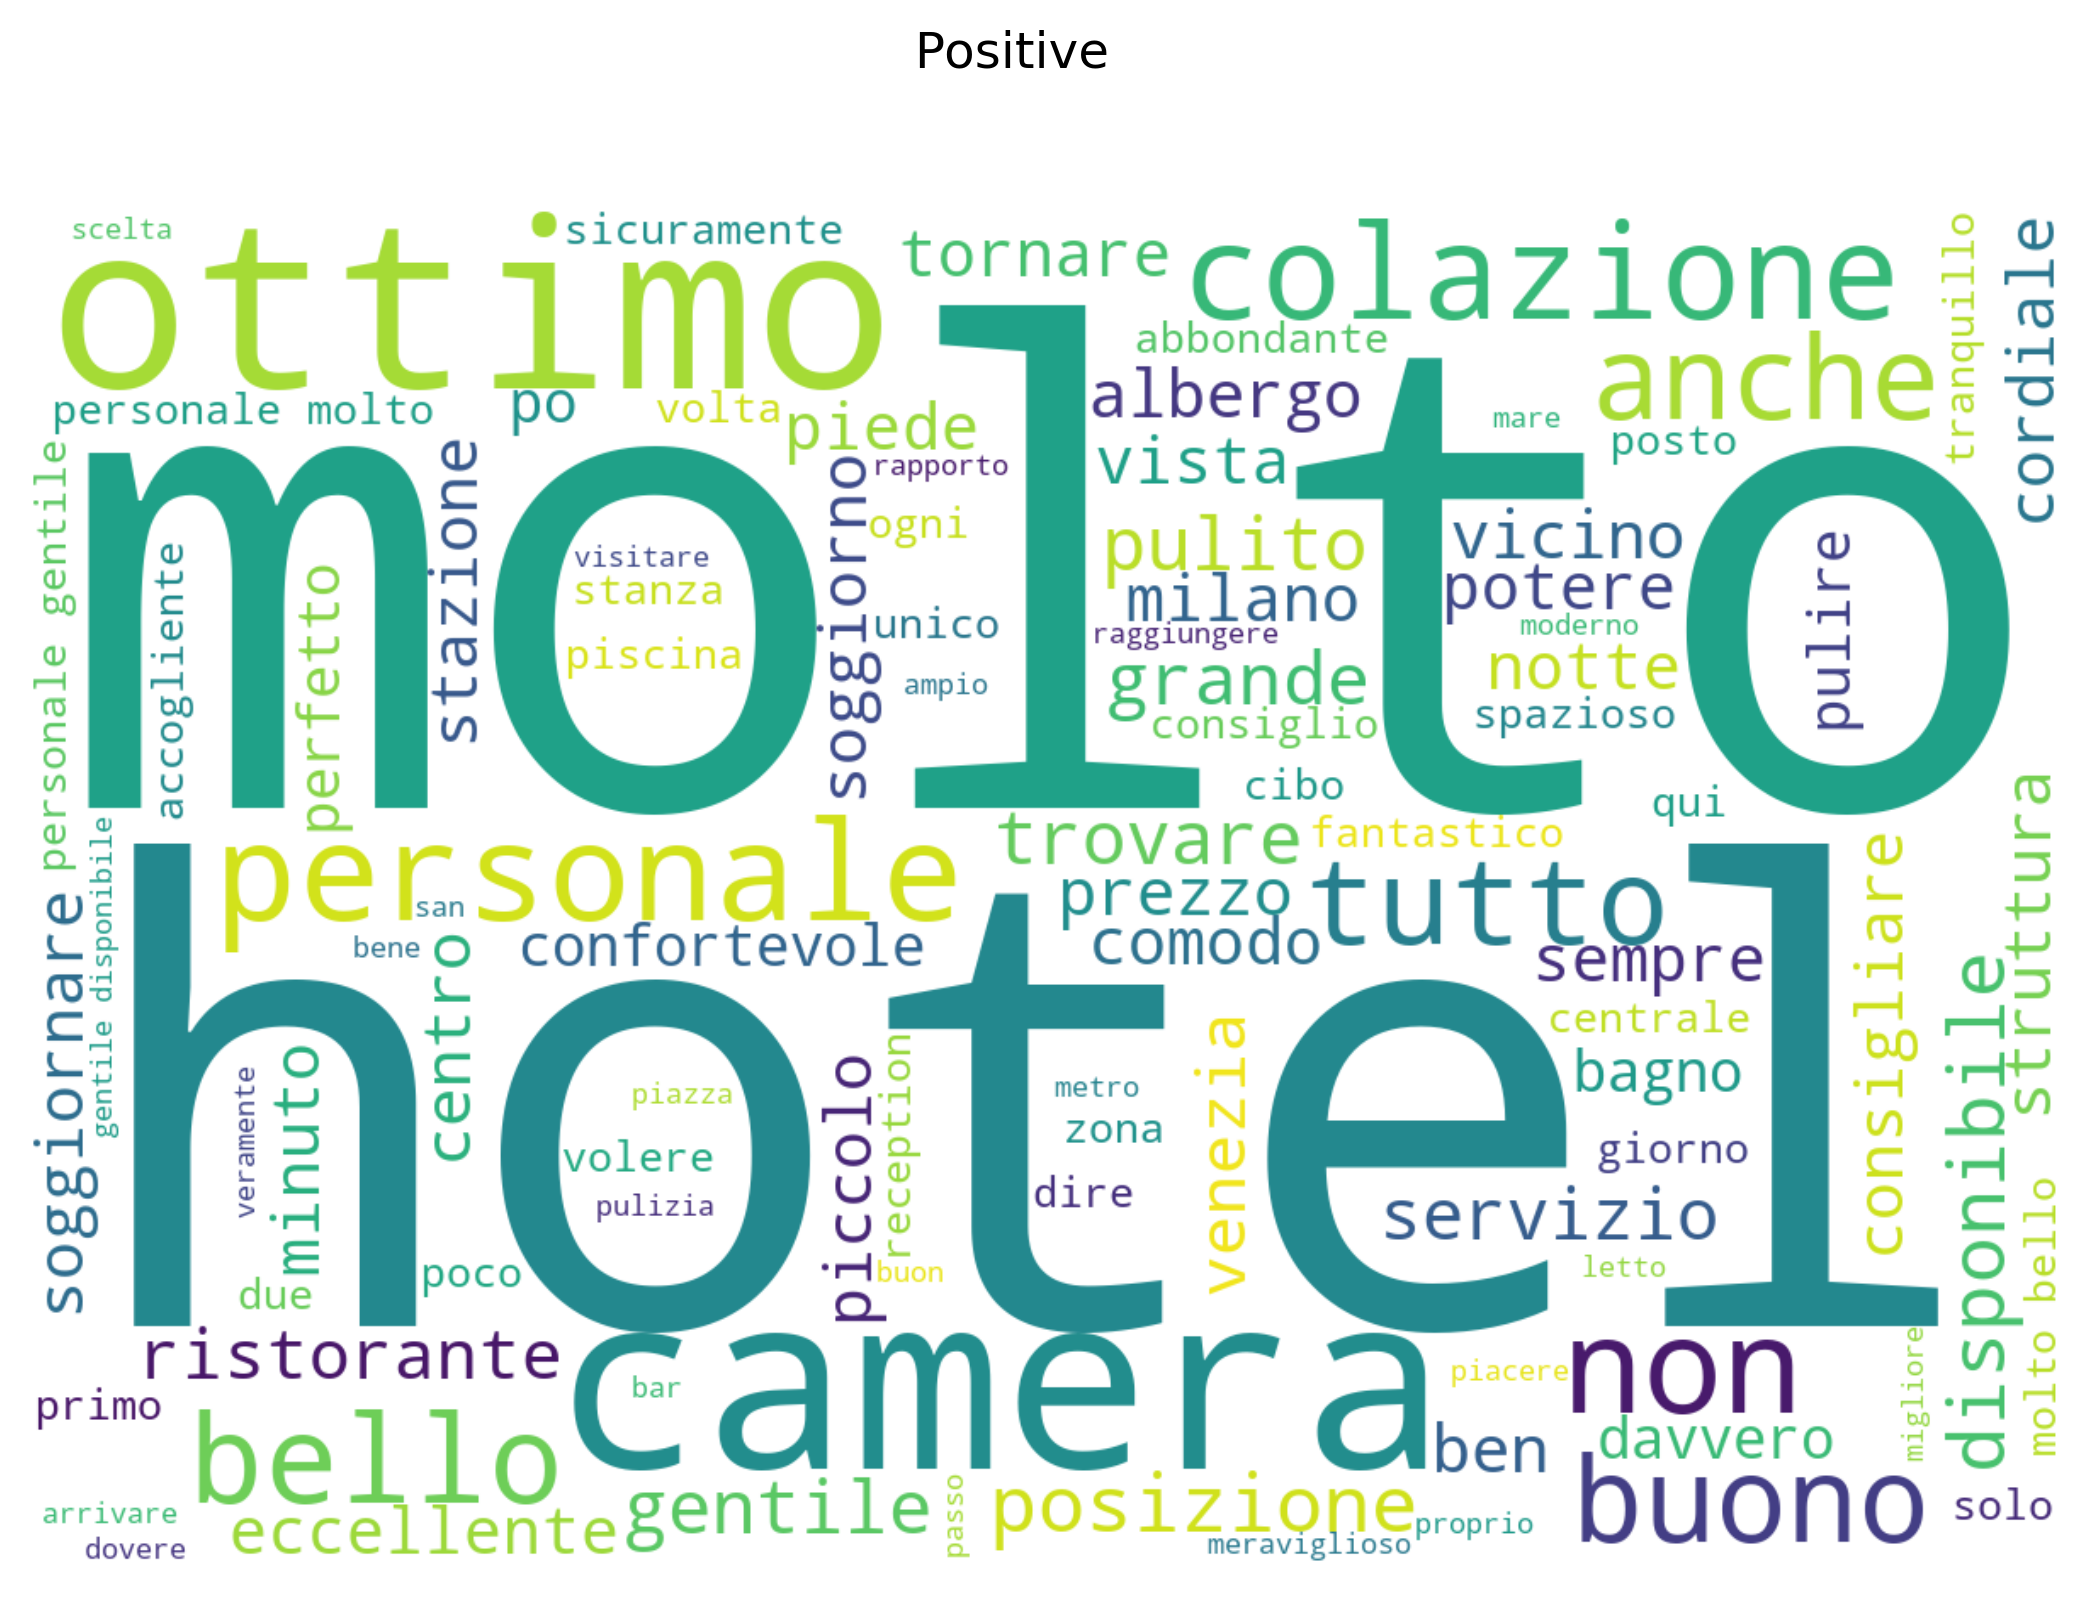

In [55]:
fig, ax = generate_wordcloud(1, X_dev_tfidf, y_dev, tfidf_vect)
fig.show()

/home/toyo/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


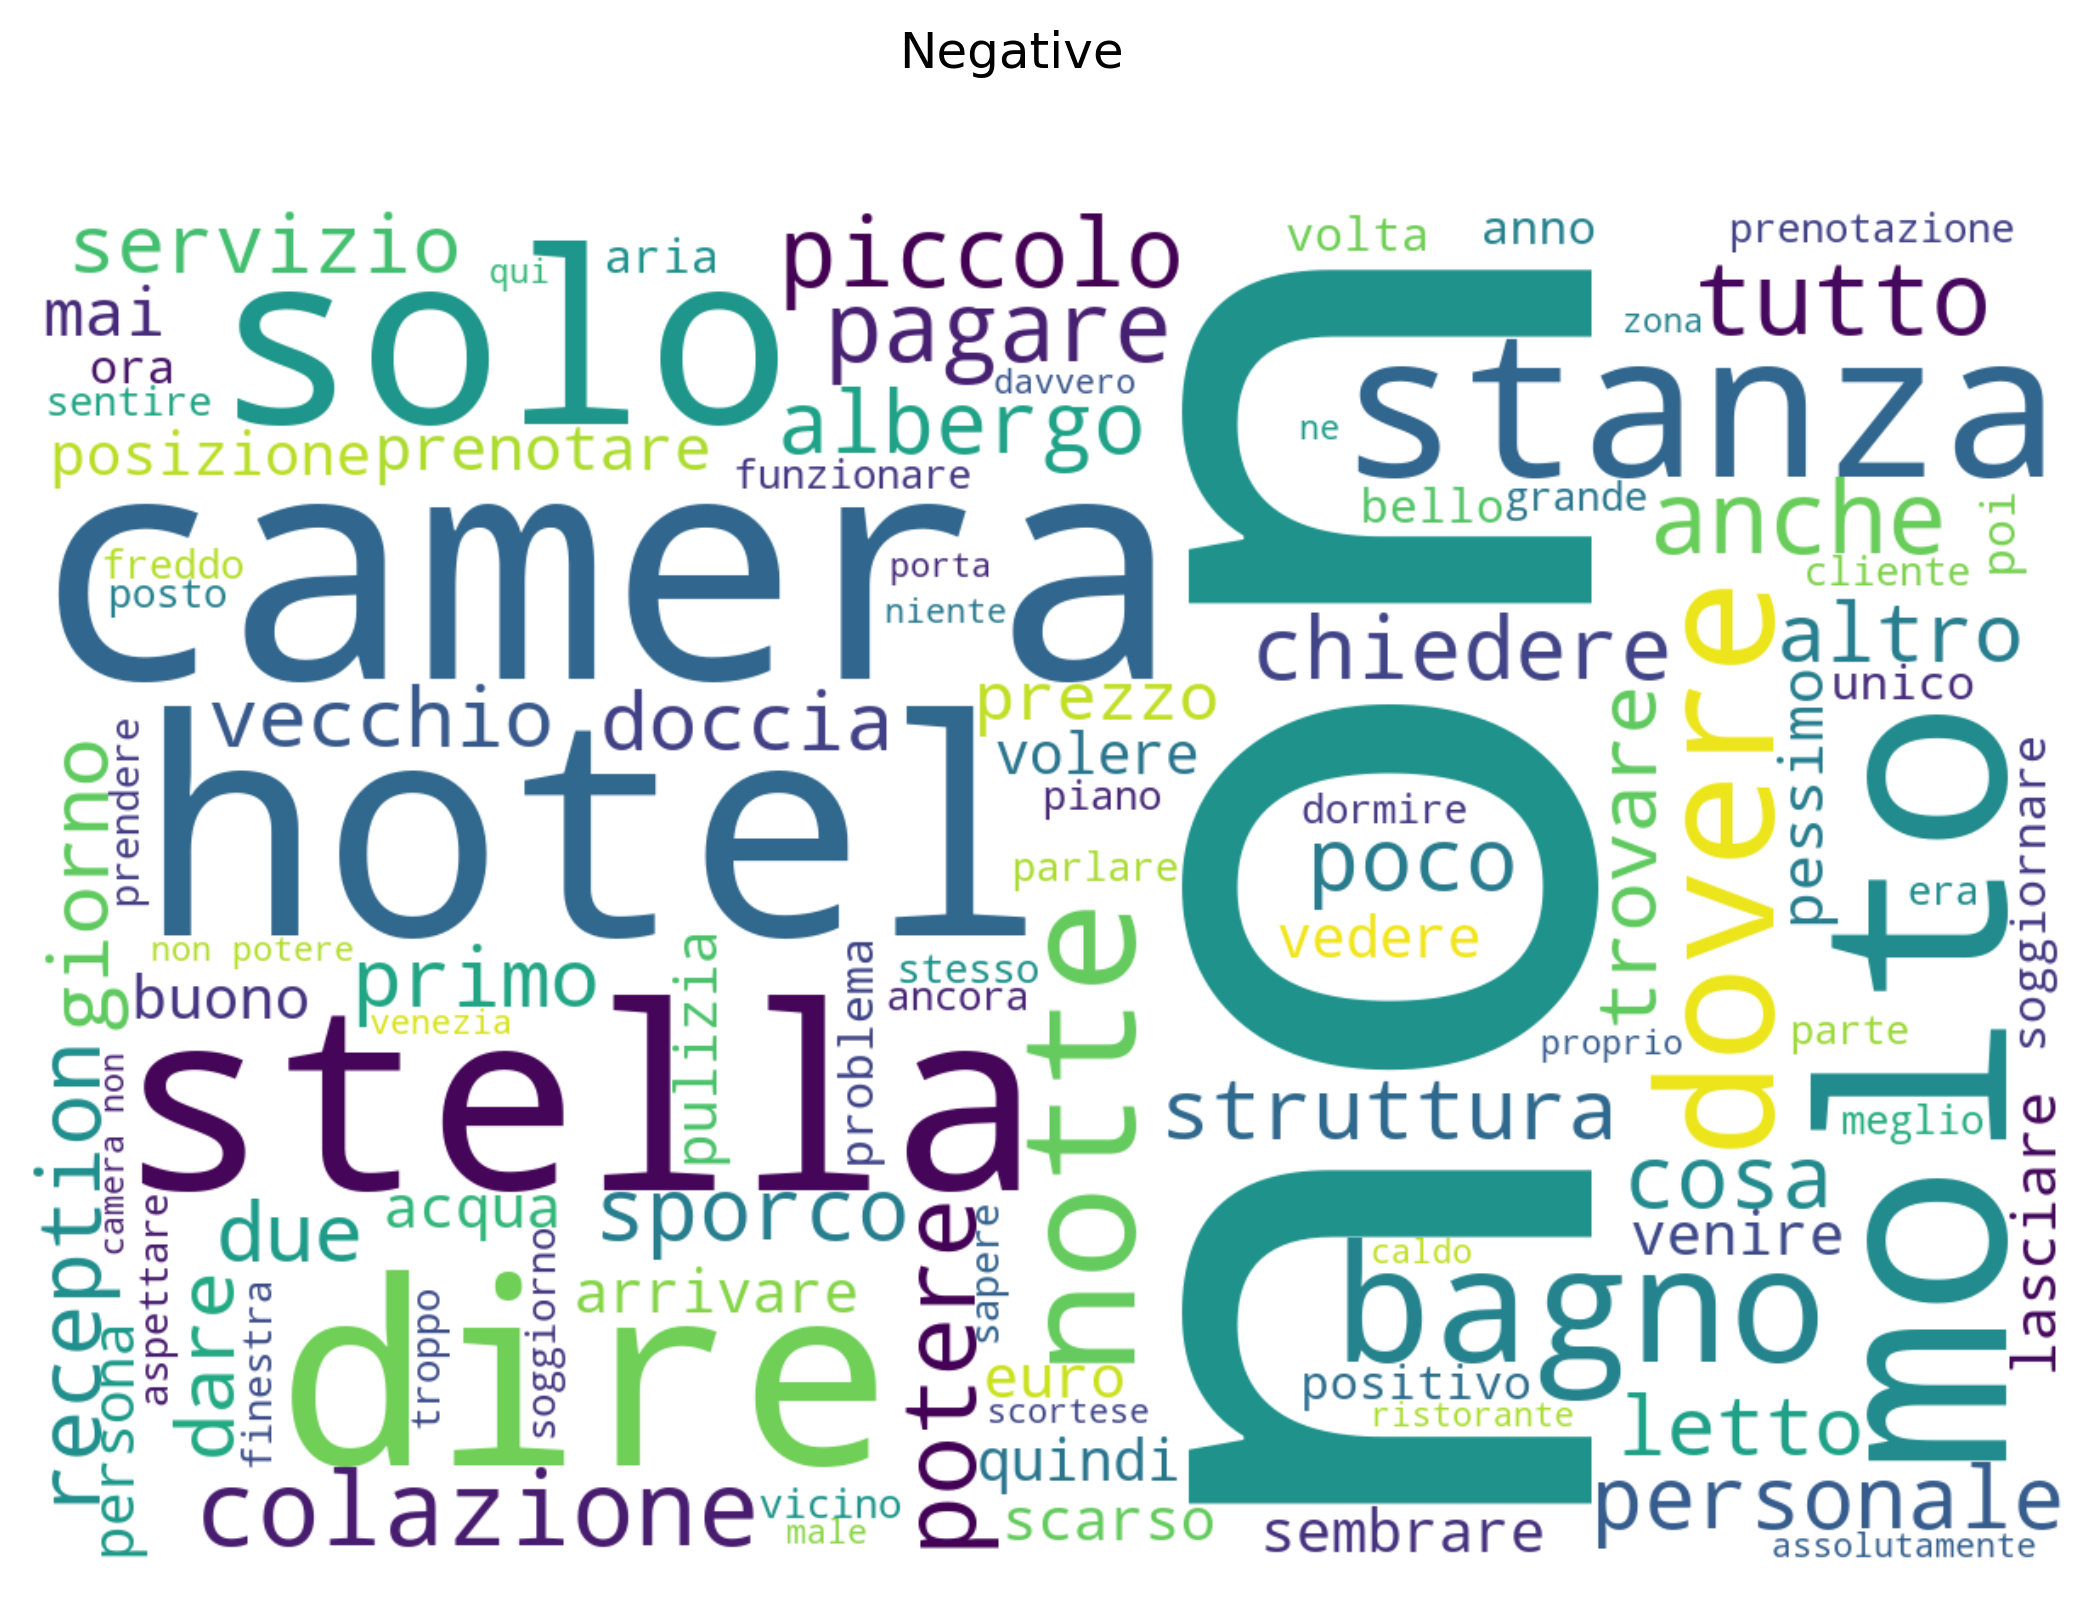

In [56]:
fig, ax = generate_wordcloud(0, X_dev_tfidf, y_dev, tfidf_vect)
fig.show()

As we can see in the figures, many words have already been recognized as characterizing.
The 'positive' one in particular shows many clearly positive words such as _'fantastico', 'bello', 'gentile'_.
However, since these wordclouds have been obtained by summing up for each word all the statistic values among the samples, very frequent words such as _'hotel'_ appear even if each single value is small (due to IDF factor as mentioned before). Therefore these figures may seem misleading and must be considered just as a coarse separation between the two classes.

## ML Algorithm

In this section, two of the most common machine learning algorithm for text sentiment analysis, _Multinomial Naive Bayes_ and _Support Vector Machine,_ are compared, since they both present advantages and disadvantages with respect to each other.

### Multinomial Naive Bayes

Naive Bayes is a popular scalable classification algorithm which makes use of Bayes Theorem for computing posterior probabilities from priors. Considering the kind of text data we are working on, Naive Bayes' efficiency becomes convenient in the case under study: hotel reviews are generally big streams of data (perhaps not as much as e-mails or tweets, but anyway very common) and Naive Bayes algorithm plays straightforwardly for updating the posterior probabilities, not suffering from high samples cardinality.

Let's cross-validate the Multinomial Naive Bayes classifier to see how it performs on our data.

In [69]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

# alpha=0.2 has been found through a parameter grid search among many values between 0 and 1
# According to Scikit-Learn documentation, alpha parameter specifies additive smoothing parameter
# (needed to avoid divisions by zero in the Bayes Law formula). Apparently, Lidstone smoothing
# performs slightly better than Laplace smoothing (alpha=1.0).
mnb = MultinomialNB(alpha=0.2)

cv_score_mnb = cross_val_score(mnb, X_dev_tfidf, y_dev,
                      scoring='f1_weighted', cv=5)

print('5-fold cross-validation with Multinomial Naive Bayes')
print(cv_score_mnb)
print(f'Mean: {np.mean(cv_score_mnb):.3f}')

5-fold cross-validation with Multinomial Naive Bayes
[0.96675336 0.9633114  0.9543676  0.95989459 0.96370352]
Mean: 0.962


As we can see, besides being blazingly fast in fitting the data, the above classifier is able to reach over 96% of _F1 score_ which is an overall great result.

### Support Vector Machine

SVM classifiers are commonly known to leave Naive Bayes classifiers behind in terms of accuracy of prediction. This is due to the fact that SVMs separe the input space into two semi-spaces trying to maximize the margin of the division hyperplane.

#### Linear SVM

As a first attempt in evaluating SVM performance, we can train a SVM classifier with linear kernel to see if it actually predict better than Naive Bayes Classifier.

In [73]:
from sklearn.svm import LinearSVC

lsvc = LinearSVC()

cv_score_lsvc = cross_val_score(lsvc, X_dev_tfidf, y_dev,
                      scoring='f1_weighted', cv=5)

print('5-fold cross-validation with SVC with linear kernel')
print(cv_score_lsvc)
print(f'Mean: {np.mean(cv_score_lsvc):.3f}')

5-fold cross-validation with SVC with linear kernel
[0.96673386 0.9696149  0.96339292 0.96329645 0.96339292]
Mean: 0.965


Here we can see that SVM with linear kernel achieves a slightly better _F1 score_ than NB. 

#### Non-linear SVM

Of course we can imagine that our data is not perfectly linearly separable, therefore we can also try with SVM with non-linear kernel. In particular Gaussian Radial Basis function kernel (RBF) turned out to work best in our case.

In [75]:
from sklearn.svm import SVC

# again, hyper-parameter values have been found by a grid search among many values
svc = SVC(C=10, gamma=1, kernel='rbf')

cv_score_svc = cross_val_score(svc, X_dev_tfidf, y_dev,
                      scoring='f1_weighted', cv=5)

print('5-fold cross-validation with SVC with RBF non-linear kernel')
print(cv_score_svc)
print(f'Mean: {np.mean(cv_score_svc):.3f}')

5-fold cross-validation with SVC with RBF non-linear kernel
[0.96862414 0.97029052 0.96404164 0.96412724 0.96423512]
Mean: 0.966


To summarize, Naive Bayes algorithm manages to reach more than acceptable F1-score on our dataset, also being fast and updatable with new data: the already trained model could be fed with additional labeled reviews to acquire more precise prior probabilities. This last property is not explicitly required for the assigned task. Nevertheless it might be significant since we are dealing with hotel reviews which consist in high-velocity stream of data.
Moreover it boasts high interpretability since the label is assigned according to simple probability measures directly related to the words in each review.

Instead, SVM is slightly more accurate in predicting labels (approx. 0.005 more in F1-score) but its efficiency and scalability are in no way close to NB's. In particular, SVM with non-linear kernel suffers a lot from big sample size data. Its training complexity is, in fact, $O(dn^2)$ where $d$ is the features dimension and $n$ the sample size, while the prediction complexity is $O(dn)$.
It's easy to see that in our case ( $n \approx 10^4$ ), given time-restricted conditions, non-linear SVM is not a desirable approach.

This being said, the competition only focuses on F1-score of the predicted labels for a given evaluation set, without time constraints, therefore the next section will address the steps that has been carried out for the model hyper-parameters tuning and validation.

## Hyper-parameter tuning and validation

Now that we've selected two candidate classifiers, we need to tune their hyper-parameters in order to get optimal performance with the given dataset.

First we adopt a _grid search_ strategy combined with _5-fold cross validation_ for deciding which combination of hyper parameters best suits our data.

In [90]:
from sklearn.model_selection import GridSearchCV

print('MultinomialNB grid search')

param_grid = {
    'alpha': [1, 0.8, 0.6, 0.4, 0.2, 0.1]
}

mnb = MultinomialNB()

mnb_gs = GridSearchCV(estimator=mnb, param_grid=param_grid,
                      n_jobs=-1, scoring='f1_weighted', cv=5)

mnb_gs.fit(X_dev_tfidf, y_dev)
print(f'Best F1-score: {mnb_gs.best_score_:.3f}')
print(f'Best hyper-parameter: {mnb_gs.best_params_}')

MultinomialNB grid search
Best F1-score: 0.962
Best hyper-parameter: {'alpha': 0.2}


Here the only parameter is `alpha`. According to [MultinomialNB Scikit-Learn documentation](https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes)
> The smoothing priors $\alpha \ge 0$ accounts for
features not present in the learning samples and prevents zero probabilities
in further computations.
Setting $\alpha = 1$ is called Laplace smoothing,
while $\alpha \lt 1$ is called Lidstone smoothing.

In [ ]:
print('SVC with RBF kernel grid search (this may take a while...)')

param_grid = {
    'C': [0.1, 1., 10],
    'gamma': [0.1, 1, 10]
}

svc = SVC(kernel='rbf')

svc_gs = GridSearch(estimator=svc, param_grid=param_grid,
                   n_jobs=-1, scoring='f1_weighted', cv=5)

svc_gs.fit(X_dev_tfidf, y_dev)
print(f'Best F1-score: {svc_gs.best_score_:.3f}')
print(f'Best hyper-parameter: {svc_gs.best_params_}')

For what concerns the `C` parameter, it trades off correct classification of training examples against maximization of the decision function’s margin. For larger values of `C`, a smaller margin will be accepted if the decision function is better at classifying all training points correctly.

Also quoting [Scikit-Learn documentation](https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html):
>...the gamma parameter defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’

In fact, the RBF kernel of two samples $\mathbf{x}$ and $\mathbf{x'}$ is defined as follows:
$$K(\mathbf{x}, \mathbf{x'}) = \exp(-\gamma\|\mathbf{x} - \mathbf{x'}\|^2)$$

and in particular it can be easily identified as a similarity measure since it takes values between $(0,1)$ [[1]](https://en.wikipedia.org/wiki/Radial_basis_function_kernel#cite_note-Chang2010-1)

Now that we have the best hyper parameters, we can validate the two models plotting the ROC curve which will give us a better insight of the accuracy of the model than the only F1-score.

In [93]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score

# create a split for both training and validating the model
X_train, X_test, y_train, y_test = train_test_split(X_dev_tfidf, y_dev, test_size=.3,
                                                    random_state=101)

mnb = MultinomialNB(alpha=0.2)

# fit a multinomial NB classifier and predict the probability of the test set
y_score = mnb.fit(X_train, y_train).predict_proba(X_test)

# compute the false positive and true positive rate for the class 'neg'
fpr, tpr, thresholds = roc_curve(y_test, y_score[:,1])

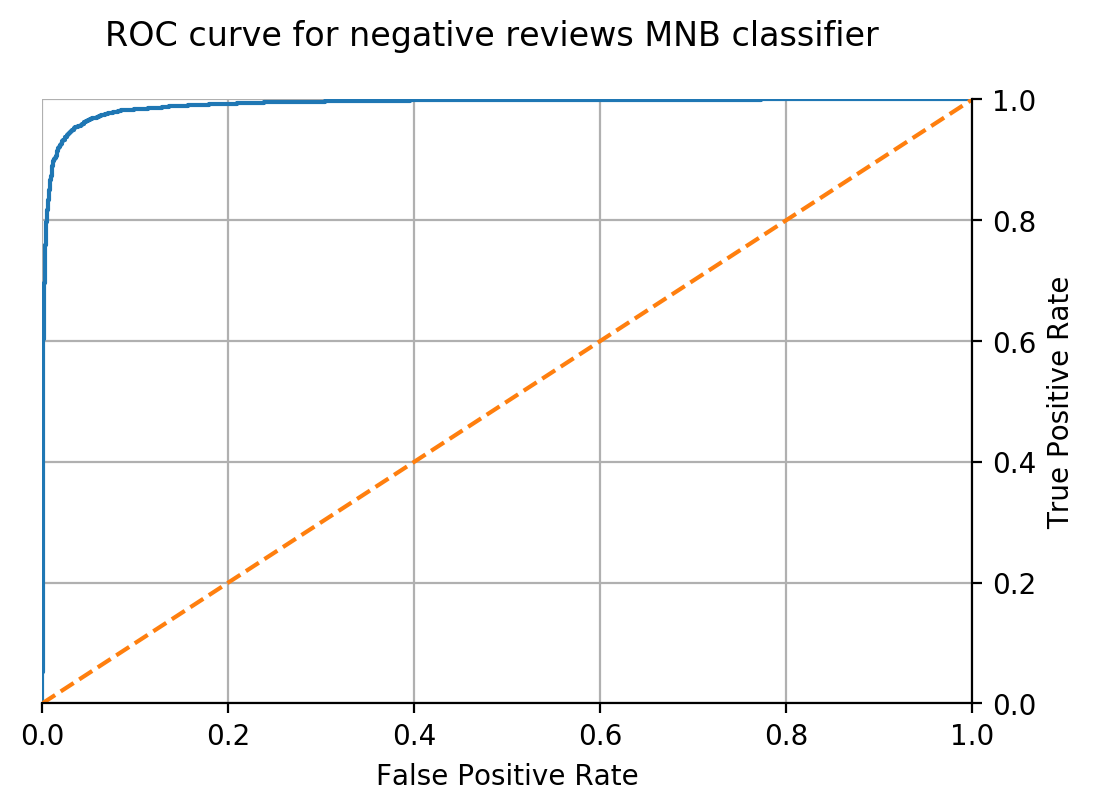

In [107]:
fig, ax = plt.subplots(dpi=200)
ax.plot(fpr, tpr)
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)
fig.suptitle('ROC curve for negative reviews MNB classifier')
ax.grid()
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.tick_right()
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.yaxis.set_label_position("right")
ax.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), linestyle='dashed')

In [95]:
print(f'ROC Area Under Curve (AUC) score: {roc_auc_score(y_test, y_score[:,1]):.4f}')

ROC Area Under Curve (AUC) score: 0.9918


As we can see, the classifier overall accuracy is so high that the ROC curve is hardly visible. Therefore it may be worth considering just the confusion matrix instead.

In [97]:
from sklearn.metrics import confusion_matrix

y_pred_mnb = mnb.predict(X_test)
mnb_cm = confusion_matrix(y_test, y_pred_mnb)

print(mnb_cm)
print(f'FP + FN = {mnb_cm[0,1] + mnb_cm[1,0]}')

[[2601  203]
 [ 132 5691]]
FP + FN = 335


We can see that 203 negative reviews has been labeled as positive, while 132 positive ones, has been labeled as negative. As we could expect, this imbalance readily reflects the original imbalance of the dataset.

In [98]:
svc = SVC(C=10, gamma=1, kernel='rbf')

# fit an SVC with RBF kernel classifier and predict the labels of the test set
y_pred_svc = svc.fit(X_train, y_train).predict(X_test)
svc_cm = confusion_matrix(y_test, y_pred_svc)

print(svc_cm)
print(f'FP + FN = {svc_cm[0,1] + svc_cm[1,0]}')

[[2631  173]
 [ 114 5709]]
FP + FN = 287


## Evaluation prediction

Finally we can train the real models to obtain the predictions of the evaluation set.

In [99]:
mnb = MultinomialNB(alpha=0.2)

mnb.fit(X_dev_tfidf, y_dev)

MultinomialNB(alpha=0.2, class_prior=None, fit_prior=True)

In [100]:
svc = SVC(C=10, gamma=1, kernel='rbf')

svc.fit(X_dev_tfidf, y_dev)

KeyboardInterrupt: 

Now we can proceed with predicting the labels. Let's first load the dataset.

In [102]:
# load the evaluation file in a pandas DataFrame
eval_df = pd.read_csv(eval_file, header=0)

Then we need to apply the same transformation as the development set, in order to have the same features known by the models.

In [103]:
X_eval_tfidf = tfidf_vect.transform(eval_df['text'])

KeyboardInterrupt: 

In [104]:
def dump_to_file(indices, labels, filename: str):
    """
    Dump the evaluated labels to a CSV file
    """
    assert len(indices) == len(labels)
    df = pd.DataFrame({'Id': indices, 'Predicted': labels})
    df.to_csv(filename, index=False)

In [ ]:
n_eval_samples = X_eval_tfidf.shape[0]

In [ ]:
y_eval_mnb = svc.predict(X_eval_tfidf)

dump_to_file(np.arange(n_eval_samples),
             list(map(lambda x: inv_lab_map[x], y_eval_mnb)),
             'output_mnb.csv')

In [ ]:
y_eval_svc = svc.predict(X_eval_tfidf)

dump_to_file(np.arange(n_eval_samples),
             list(map(lambda x: inv_lab_map[x], y_eval_svc)),
             'output_svc.csv')